# Fastai Callbacks

### Useful links
* [Medium post implementing simple version of callback system](https://medium.com/@edwardeasling/implementing-callbacks-in-fast-ai-1c23de25b6eb)
* [Fastai docs on callbacks](https://docs.fast.ai/callback.html#Callback)


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import PIL
PIL.PILLOW_VERSION = PIL.__version__

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
bs = 512
path = untar_data(URLs.MNIST)

In [ ]:
def _inverse_colours(x):
    x.data = 1 - x.data
    return x
inverse_colours = TfmPixel(_inverse_colours)
tfms = get_transforms(do_flip=False )
tfms = [tfms[0]+ [inverse_colours()], tfms[1]+ [inverse_colours()]]

In [ ]:
data = ImageDataBunch.from_folder(
    path, 
    valid_pct=0.1, 
    ds_tfms=tfms,
    size=26, 
    bs=bs
    ).normalize(mnist_stats)

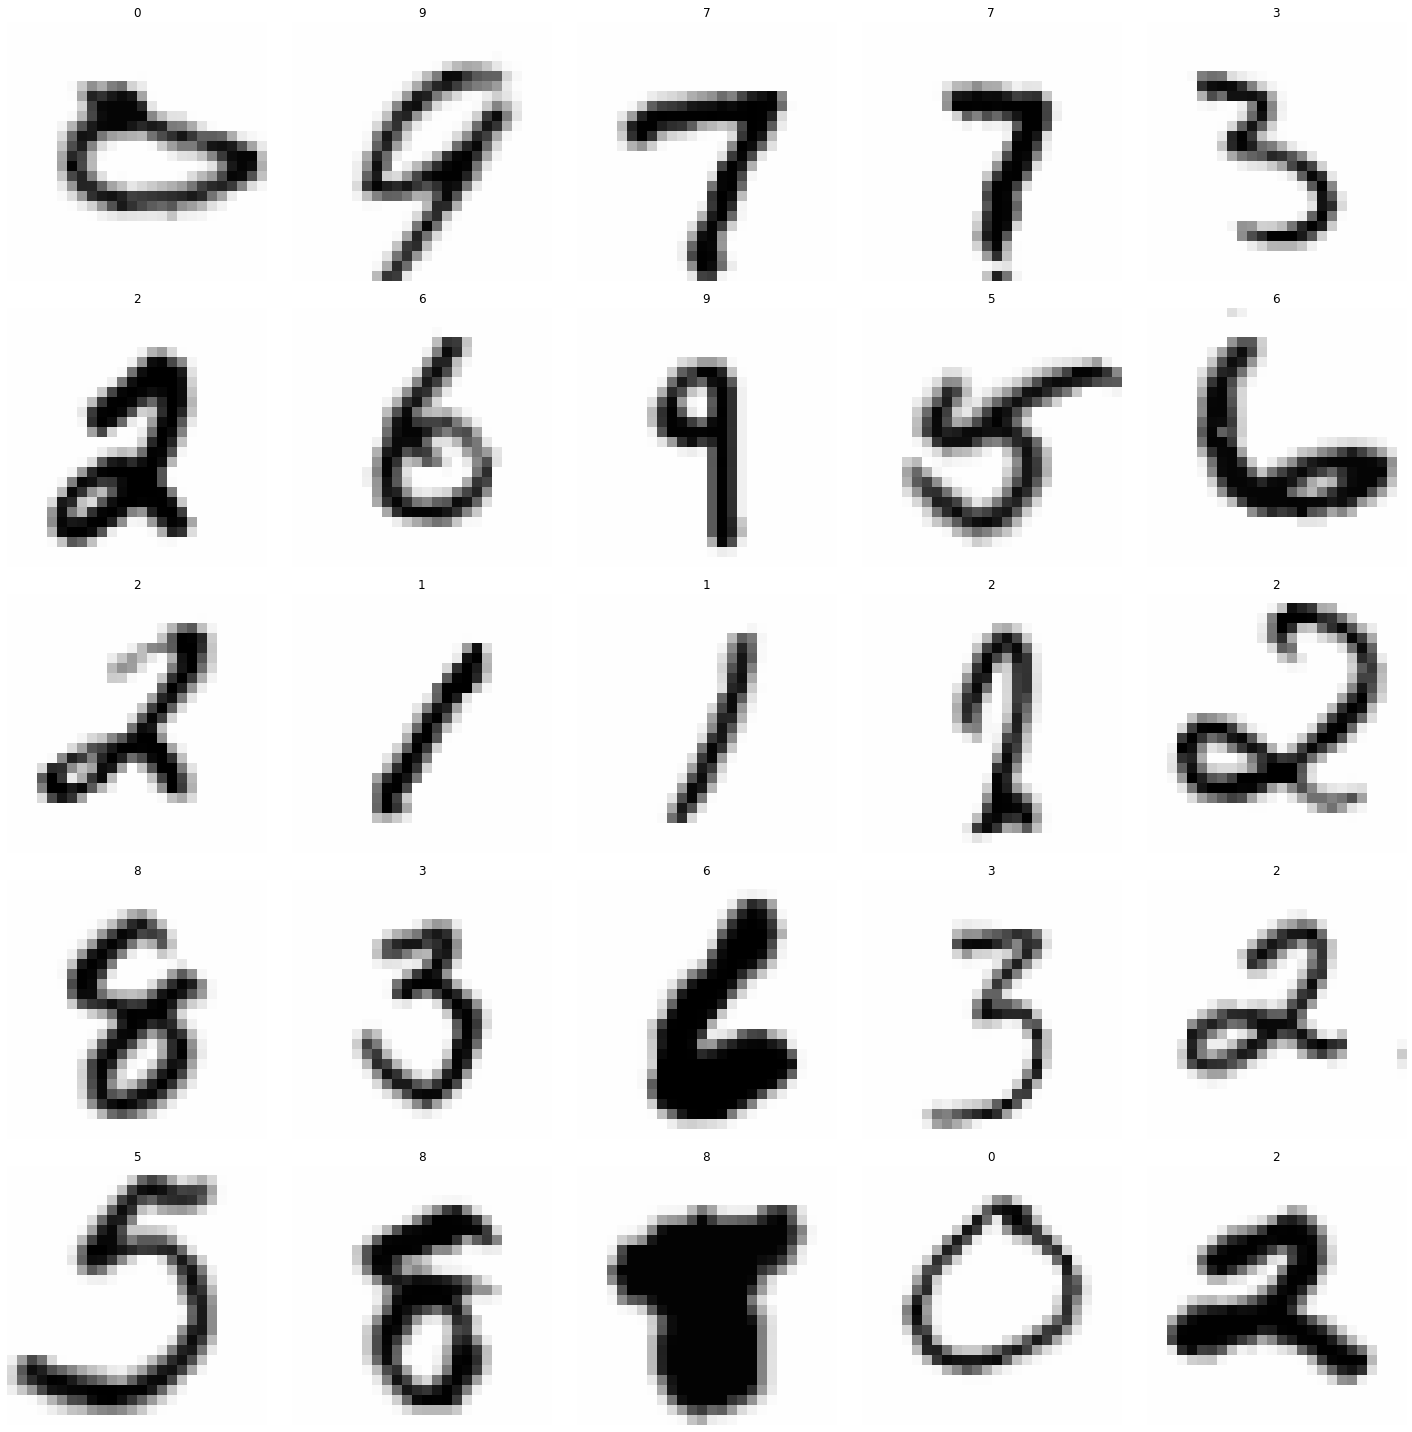

In [ ]:
data.show_batch()

In [ ]:
class PrintCallback(LearnerCallback):
    def on_epoch_end(self, iteration: int, num_batch: int, **kwargs):
        print('Epoch ended', iteration, num_batch)
        

class SilenceRecorder(LearnerCallback):
    def __post_init__(self):
      self.learn.recorder.silent = True


class SimpleRecorder(LearnerCallback):
    def on_train_begin(self, **kwargs:Any)->None:
        self.losses = []
    def on_step_end(self, iteration: int, last_loss, **kwargs ):
        self.losses.append(last_loss)
    def on_epoch_end(self, last_loss, smooth_loss, **kwarg):
        print('Epoch ended', last_loss, smooth_loss)
    def on_epoch_end(self, **kwargs):
        losses = self.losses
        iterations = range(len(losses))
        fig, ax = plt.subplots(1,1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Iteration')
        ax.plot(iterations, losses)

In [ ]:
%matplotlib inline

In [ ]:
from ipywidgets import Output
from IPython.display import display, clear_output

In [ ]:
o = Output()
o

Output()

In [ ]:
altair bokeh

epoch,train_loss,valid_loss,error_rate,time
0,0.873479,0.417568,0.134286,00:12
1,0.521711,0.320771,0.102571,00:12


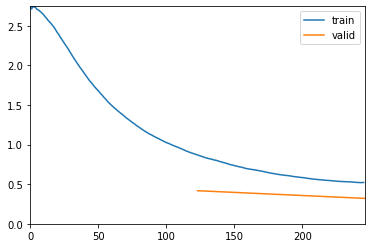

In [ ]:
learn.fit_one_cycle(2)

In [ ]:
learn = cnn_learner(data, 
                    models.resnet34, 
                    metrics=error_rate, 
                    callback_fns=[
                        PrintCallback,
#                         SilenceRecorder, 
#                         ShowGraph
                    ]
                    )

In [ ]:
learn.predict??

In [ ]:
123*512

62976

In [ ]:
Recorder??

In [ ]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False),
 __main__.PrintCallback]

## Multithreading

Access losses during training in main thread

In [ ]:
import threading
# from iterable_queue import IterableQueue
from functools import partial
            
from queue import Queue

class IterableQueue(Queue): 

    _sentinel = object()

    def __iter__(self):
        return iter(self.get, self._sentinel)

    def close(self):
        self.put(self._sentinel)
    
class NewRecorder(Recorder):
    def __init__(self,   learn:Learner, add_time:boool=True, silent:bool=False, q: IterableQueue=IterableQueue()):
        super().__init__(learn, add_time, silent)
        self.q = q
    def on_epoch_end(self, last_loss, **kwargs):
        self.q.put(last_loss)

    def on_train_end(self, **kwargs):
        print('training ended')
        self.q.close()
        
class MultiThreaded:
    def __init__(self, learn: Learner, data:DataBunch, cbs):
        self.q = IterableQueue()
        self.learn = learn(data, 
                    models.resnet34, 
                    metrics=error_rate, 
                    callback_fns=[partial(NewRecorder, q=self.q)])
    def fit(self, epochs: int):
        thread = threading.Thread(target=self.learn.fit_one_cycle, args=(epochs,))
        thread.start()
    def print_items(self):
        for item in self.q:
            print(item)
            
multi_threaded_learner = MultiThreaded(cnn_learner, data, [SimpleRecorder, ShowGraph])

In [ ]:
multi_threaded_learner.fit(2)

epoch,train_loss,valid_loss,error_rate,time
epoch,train_loss,valid_loss,error_rate,time
0,0.879451,0.416031,0.135000,00:12
1,0.519889,0.318656,0.102857,00:12


training ended


In [ ]:
multi_threaded_learner.q.put('a')

In [ ]:
for i in multi_threaded_learner.q:
    print(i)

TypeError: eq() received an invalid combination of arguments - got (object), but expected one of:
 * (Tensor other)
      didn't match because some of the arguments have invalid types: ([31;1mobject[0m)
 * (Number other)
      didn't match because some of the arguments have invalid types: ([31;1mobject[0m)


## Reverse fit_one_cylce

Use callbacks to start with high learning rate and small momentum, decrease and then increase lr and do the inverse to momentum. Copied the `OneCycleScheduler` from the [fastai source code](https://github.com/fastai/fastai/blob/master/fastai/callbacks/one_cycle.py#L8) and modified the `on_train_begin` function.

In [ ]:
class ReverseOneCycleScheduler(LearnerCallback):
    "Reverse the learning rate and momentum cycling of the one cycle policy."
    def __init__(self, learn:Learner, lr_max:float, moms:Floats=(0.95,0.85), div_factor:float=25., pct_start:float=0.3,
                 final_div:float=None, tot_epochs:int=None, start_epoch:int=None):
        super().__init__(learn)
        self.lr_max,self.div_factor,self.pct_start,self.final_div = lr_max,div_factor,pct_start,final_div
        if self.final_div is None: self.final_div = div_factor*1e4
        self.moms=tuple(listify(moms,2))
        if is_listy(self.lr_max): self.lr_max = np.array(self.lr_max)
        self.start_epoch, self.tot_epochs = start_epoch, tot_epochs

    def steps(self, *steps_cfg:StartOptEnd):
        "Build anneal schedule for all of the parameters."
        return [Scheduler(step, n_iter, func=func)
                for (step,(n_iter,func)) in zip(steps_cfg, self.phases)]

    def on_train_begin(self, n_epochs:int, epoch:int, **kwargs:Any)->None:
        "Initialize our optimization params based on our annealing schedule."
        res = {'epoch':self.start_epoch} if self.start_epoch is not None else None
        self.start_epoch = ifnone(self.start_epoch, epoch)
        self.tot_epochs = ifnone(self.tot_epochs, n_epochs)
        n = len(self.learn.data.train_dl) * self.tot_epochs
        a1 = int(n * self.pct_start)
        a2 = n-a1
        self.phases = ((a1, annealing_cos), (a2, annealing_cos))
        low_lr = self.lr_max/self.div_factor
        # Start with maximum lr and go to lowest and back       
        self.lr_scheds = self.steps(( self.lr_max, low_lr,), (low_lr, self.lr_max))
        # Reverse for momentum
        self.mom_scheds = self.steps((self.moms[1], self.moms[0]), self.moms)
        self.opt = self.learn.opt
        self.opt.lr,self.opt.mom = self.lr_scheds[0].start,self.mom_scheds[0].start
        self.idx_s = 0
        return res
    
        #     def jump_to_epoch(self, epoch:int)->None:
        #         for _ in range(len(self.learn.data.train_dl) * epoch):
        #             self.on_batch_end(True)

    def on_batch_end(self, train, **kwargs:Any)->None:
        "Take one step forward on the annealing schedule for the optim params."
        if train:
            if self.idx_s >= len(self.lr_scheds): return {'stop_training': True, 'stop_epoch': True}
            self.opt.lr = self.lr_scheds[self.idx_s].step()
            self.opt.mom = self.mom_scheds[self.idx_s].step()
            # when the current schedule is complete we move onto the next
            # schedule. (in 1-cycle there are two schedules)
            if self.lr_scheds[self.idx_s].is_done:
                self.idx_s += 1

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Tell Learner to stop if the cycle is finished."
        if epoch > self.tot_epochs: return {'stop_training': True}

a
b


KeyboardInterrupt: 

Process Process-370:
Traceback (most recent call last):
  File "/home/sascha/miniconda3/envs/fastai/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sascha/miniconda3/envs/fastai/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sascha/miniconda3/envs/fastai/lib/python3.7/site-packages/iterable_queue/iq.py", line 227, in _manage
    message = _manage_queue.get()
  File "<string>", line 2, in get
  File "/home/sascha/miniconda3/envs/fastai/lib/python3.7/multiprocessing/managers.py", line 819, in _callmethod
    kind, result = conn.recv()
  File "/home/sascha/miniconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/sascha/miniconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/sascha/miniconda3/envs/fastai/lib/python3.7/multipr

In [ ]:
reverse_learn = cnn_learner(data, 
                    models.resnet34, 
                    metrics=error_rate, 
                    callback_fns=[ReverseOneCycleScheduler])

In [ ]:
reverse_learn.fit()

NameError: name 'reverse_learn' is not defined

In [ ]:
learn.recorder.plot_lr(show_moms=True)